In [3]:
! python3 -m pip install --upgrade pip
! python3 -m pip install --upgrade SpeechRecognition
! python3 -m pip install --upgrade pydub
! python3 -m pip install --upgrade sklearn
! python3 -m pip install --upgrade pylangacq

     |████████████████████████████████| 1.5MB 7.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 32.8 MB 61 kB/s 
     |████████████████████████████████| 66 kB 3.2 MB/s 


In [4]:
import IPython.display as ipd
import librosa
import librosa.display
import kapre
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import io
import os
import pandas as pd
import random
import re
import shutil
import speech_recognition as sr
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from os import path
from plotnine import *
from pydub import AudioSegment
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from pydub.silence import split_on_silence 

# Cloud storage
from google.cloud import storage

# .cha file reader
import pylangacq

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Transcribe audio data to txt data

In [4]:
# !ls '/content/drive/My Drive/Berkeley/W210/Capstone/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/'

In [5]:
# initialize the speech recognizer
r = sr.Recognizer()

# a function that splits the audio file into chunks 
# and applies speech recognition 
def silence_based_conversion(path, wav_file): 
    text_df = pd.DataFrame()
  
    # open the audio file stored in 
    # the local system as a wav file. 
    song = AudioSegment.from_wav(path + wav_file) 
    print(song)
  
    # open a file where we will concatenate   
    # and store the recognized text 
    text_file = wav_file.partition('.')[0] + ".txt"
    text_file_dir = path + "output_text/" 
    if not os.path.exists(text_file_dir):
        os.makedirs(text_file_dir)    
    text_file_path = text_file_dir + text_file
    fh = open(text_file_path, "w+") 
          

    dBFS = song.dBFS
    print('dBFS: ' + str(dBFS))
    # chunks = split_on_silence(song, 
    #     min_silence_len = 500,
    #     silence_thresh = dBFS-16,
    #     keep_silence = 250 
    # )

    # split track where silence is 0.5 seconds  
    # or more and get chunks 
    chunks = split_on_silence(song, 
        # must be silent for at least 0.5 seconds 
        # or 500 ms. adjust this value based on user 
        # requirement. if the speaker stays silent for  
        # longer, increase this value. else, decrease it. 
        min_silence_len = 250, 
  
        # consider it silent if quieter than -16 dBFS 
        # adjust this per requirement 
        silence_thresh = dBFS - 16
        # keep_silence = 250
    ) 
    # setting minimum length of each chunk to 25 seconds
    target_length = 20 * 1000 
    output_chunks = [chunks[0]]
    for chunk in chunks[1:]:
      print('Length of chunk: ' + str(len(output_chunks[-1])) )
      if len(output_chunks[-1]) < target_length:
        output_chunks[-1] += chunk
      else:
        # if the last output chunk is longer than the target length,
        # we can start a new one
        output_chunks.append(chunk)    
    # print(chunks)
  
    # create a directory to store the audio chunks. 
    try: 
        os.mkdir(path + 'audio_chunks') 
    except(FileExistsError): 
        pass
  
    # move into the directory to 
    # store the audio files. 
    os.chdir(path +'audio_chunks') 
  
    i = 0
    # process each chunk 
    for chunk in output_chunks: 
              
        # Create 0.5 seconds silence chunk 
        chunk_silent = AudioSegment.silent(duration = 10) 
  
        # add 0.5 sec silence to beginning and  
        # end of audio chunk. This is done so that 
        # it doesn't seem abruptly sliced. 
        audio_chunk = chunk_silent + chunk + chunk_silent 
  
        # export audio chunk and save it in  
        # the current directory. 
        text_file_id = text_file.partition('.')[0]
        chunk_file_name = text_file_id + "_" + "chunk" + str(i) + ".wav"
        print("saving " + chunk_file_name) 
        # specify the bitrate to be 192 k 
        audio_chunk.export("./" + chunk_file_name, bitrate ='192k', format ="wav") 
  
        # the name of the newly created chunk 
        filename = chunk_file_name
  
        print("Processing chunk file: " + filename) 
  
        # get the name of the newly created chunk 
        # in the AUDIO_FILE variable for later use. 
        file = filename 
  
        # create a speech recognition object 
        r = sr.Recognizer() 
  
        # recognize the chunk 
        with sr.AudioFile(file) as source: 
            # remove this if it is not working 
            # correctly. 
            #r.adjust_for_ambient_noise(source) 
            audio_listened = r.record(source) 
  
        try: 
            # try converting it to text 
            rec = r.recognize_google(audio_listened) 
            # write the output to the file. 
            fh.write(rec+". ") 
            text_df = text_df.append({'ID': text_file_id, 'Text': rec}, ignore_index = True)
  
        # catch any errors. 
        except sr.UnknownValueError: 
            print("Could not understand audio") 
  
        except sr.RequestError as e: 
            print("Could not request results. check your internet connection") 
  
        i += 1
    return text_df

# silence_based_conversion(audio_path_cc, 'S001.wav')        
# text_df = silence_based_conversion(audio_path_cd, 'S079.wav')        
# print(text_df)
# silence_based_conversion(audio_path_cc + 'spkr0.wav')        

## Read csv data file with ID, TEXT and MMSE scores to be used for training and validation

In [4]:
data_path = '/content/drive/My Drive/Berkeley/W210/Capstone/ADReSS-IS2020-data/train'

transcription_combination_txt_file_path = data_path + "/transcription_shuffled_text/" + "transcription_combination_id_txt_mmse.csv"
filtered_merged_data = pd.read_csv(transcription_combination_txt_file_path)
filtered_merged_data.tail()

,Unnamed: 0,ID,Age,Gender,TEXT,MMSE,Group
1395,1395,S156,71,female,he was climbing and the stool tipped over . t...,13,cd
1396,1396,S156,71,female,and she's watching . he was climbing and the ...,13,cd
1397,1397,S156,71,female,oh ‡ no . well this one is in the cookie jar ...,13,cd
1398,1398,S156,71,female,this boy tried to get in the cookie jar . oh ...,13,cd
1399,1399,S156,71,female,and she's watching . mhm . well this one is i...,13,cd


# BERT Transfer Learning

In [6]:
!pip install transformers==3.0.2

     |████████████████████████████████| 769 kB 8.5 MB/s 
     |████████████████████████████████| 883 kB 10.4 MB/s 
     |████████████████████████████████| 3.0 MB 33.0 MB/s 
     |████████████████████████████████| 1.2 MB 37.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893258 sha256=46fdaec3e66a91e455992aabd4075b46b5bfd6c99e9c63464db33ce2fe50cf38
  Stored in directory: /root/.cache/pip/wheels/69/09/d1/bf058f7d6fa0ecba2ce7c66be3b8d012beb4bf61a6e0c101c0
Successfully built sacremoses


In [7]:
from transformers import BertTokenizer
bert_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_name,
                                          add_special_tokens=True,
                                          do_lower_case=True,
                                          max_length=256,
                                          pad_to_max_length=True)


In [8]:
def bert_encoder(input_text):
    # txt = input_text.numpy().decode('utf-8')
    txt = input_text
    encoded = tokenizer.encode_plus(txt, add_special_tokens=True, 
                                    max_length=256, 
                                    pad_to_max_length=True, 
                                    return_attention_mask=True, 
                                    return_token_type_ids=True,
                                    truncation=True)
    return encoded['input_ids'], encoded['token_type_ids'], \
           encoded['attention_mask']

In [9]:
bert_train = [bert_encoder(r) for r in filtered_merged_data["TEXT"]]
bert_lbl = filtered_merged_data["MMSE"]
bert_train = np.array(bert_train)
# bert_lbl = tf.keras.utils.to_categorical(bert_lbl)

In [10]:
# create training and validation splits
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(bert_train, 
                                         bert_lbl,
                                         test_size=0.2, 
                                         random_state=42)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1120, 3, 256) (1120,)
(280, 3, 256) (280,)


In [11]:
tr_reviews, tr_segments, tr_masks = np.split(x_train, 3, axis=1)
val_reviews, val_segments, val_masks = np.split(x_val, 3, axis=1)
tr_reviews = tr_reviews.squeeze()
tr_segments = tr_segments.squeeze()
tr_masks = tr_masks.squeeze()
val_reviews = val_reviews.squeeze()
val_segments = val_segments.squeeze()
val_masks = val_masks.squeeze()

In [23]:
def example_to_features(input_ids,attention_masks,token_type_ids,y):
  return {"input_ids": input_ids,
          "attention_mask": attention_masks,
          "token_type_ids": token_type_ids},y


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((tr_reviews, 
tr_masks, tr_segments, y_train)).\
            map(example_to_features).shuffle(100).batch(16)
valid_ds = tf.data.Dataset.from_tensor_slices((val_reviews, 
val_masks, val_segments, y_val)).\
            map(example_to_features).shuffle(100).batch(16)

In [13]:
train_ds

<BatchDataset shapes: ({input_ids: (None, 256), attention_mask: (None, 256), token_type_ids: (None, 256)}, (None,)), types: ({input_ids: tf.int64, attention_mask: tf.int64, token_type_ids: tf.int64}, tf.int64)>

In [15]:
# from transformers import TFBertForSequenceClassification
# bert_model = TFBertForSequenceClassification.from_pretrained(bert_name, num_labels=31)

In [16]:
# # optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="sparse_categorical_crossentropy")
# # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# # metrics = tf.metrics.CategoricalCrossentropy()
# # bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=2e-5)
# bert_model.compile(optimizer = optimizer, 
#                    loss=tf.keras.metrics.mean_squared_error,
#                    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [17]:
# print("Fine-tuning BERT on Training data")
# bert_history = bert_model.fit(train_ds, epochs=25, 
#                               validation_data=valid_ds)

In [9]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='relu')(cls_token)
#     run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    model = Model(inputs=input_word_ids, outputs=out)
    for layer in model.layers[:-1]:
      layer.trainable = False
    # model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy']) #, options = run_opts)
    # optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=2e-5)
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer = optimizer, 
                  loss=tf.keras.metrics.mean_squared_error,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

In [10]:
import transformers
MAX_LEN = 256
# with strategy.scope():
def create_model():
  transformer_layer = (
      transformers.TFAutoModelWithLMHead.from_pretrained(bert_name)
  )
  model = build_model(transformer_layer, max_len=MAX_LEN)
  return model


In [31]:
model = create_model()
model.summary()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForMaskedLM: ['nsp___cls']
- This IS expected if you are initializing TFBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
tf_bert_for_masked_lm_2 (TFB ((None, 256, 30522),)     110104890 
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 30522)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 30523     
Total params: 110,135,413
Trainable params: 30,523
Non-trainable params: 110,104,890
_________________________________________________________________


In [37]:
checkpoint_path = "/content/drive/My Drive/Berkeley/W210/Capstone/BERT_Model_Transcription/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_loss', 
                                                 patience=50, 
                                                 restore_best_weights=True,
                                                 verbose=1)

# es_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', 
#     patience=50, 
#     restore_best_weights=True)

print("Fine-tuning BERT on Training data")
bert_history = model.fit(train_ds, 
                         epochs=1000, 
                         validation_data=valid_ds,
                         callbacks=[cp_callback])

Fine-tuning BERT on Training data
Epoch 1/1000
70/70 [==============================] - 12s 165ms/step - loss: 44.1184 - rmse: 6.6422 - val_loss: 43.1839 - val_rmse: 6.5714

Epoch 00001: saving model to /content/drive/My Drive/Berkeley/W210/Capstone/BERT_Model_Transcription/training_1/cp.ckpt
Epoch 2/1000
70/70 [==============================] - 12s 165ms/step - loss: 43.3296 - rmse: 6.5825 - val_loss: 42.7506 - val_rmse: 6.5384

Epoch 00002: saving model to /content/drive/My Drive/Berkeley/W210/Capstone/BERT_Model_Transcription/training_1/cp.ckpt
Epoch 3/1000
70/70 [==============================] - 12s 165ms/step - loss: 42.9985 - rmse: 6.5573 - val_loss: 37.1734 - val_rmse: 6.0970

Epoch 00003: saving model to /content/drive/My Drive/Berkeley/W210/Capstone/BERT_Model_Transcription/training_1/cp.ckpt
Epoch 4/1000
70/70 [==============================] - 12s 166ms/step - loss: 42.3397 - rmse: 6.5069 - val_loss: 36.9305 - val_rmse: 6.0770

Epoch 00004: saving model to /content/drive/My

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


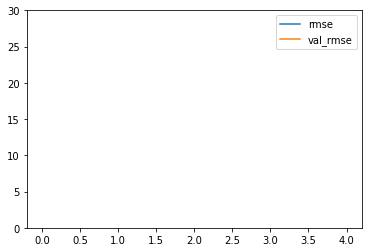

In [22]:
metrics = bert_history.history
plt.plot(bert_history.epoch, np.sqrt(metrics['rmse'])*30, np.sqrt(metrics['val_rmse'])*30)
plt.legend(['rmse', 'val_rmse'])
axes = plt.axes()
axes.set_ylim([0, 30])
plt.show()

# Evaluation and prediction based on BERT model

In [23]:
print("Evaluate on vale data")
results = model.evaluate(val_reviews, y_val, batch_size=64)
print("val rmse:", np.sqrt(results)[0])

Evaluate on vale data
5/5 [==============================] - 5s 353ms/step - loss: 54.5263 - rmse: 7.3842
val rmse: 7.384193250927349


In [24]:
result = model.predict(train_ds)
result

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['attention_mask', 'token_type_ids'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


array([[25.232538],
       [22.802418],
       [23.4632  ],
       ...,
       [27.085352],
       [27.006544],
       [25.301317]], dtype=float32)